In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


## Module Input

In [3]:
pwd

'/kaggle/working'

In [4]:
import datetime
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Loading data

In [5]:
test = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv", dtype={'ID': 'int32', 'shop_id': 'int32', 'item_id': 'int32'})
item_categories = pd.read_csv("../input/competitive-data-science-predict-future-sales/item_categories.csv", dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv", dtype={'item_name': 'str', 'item_id': 'int32', 'item_category_id': 'int32'})
shops = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv", dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv", dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'}, 
                    parse_dates=['date'])



In [6]:
train = sales.join(items, on='item_id', rsuffix='_tmp').join(shops, on='shop_id', rsuffix='_tmp').join(item_categories, on='item_category_id', rsuffix='_tmp').drop(columns=['item_id_tmp', 'shop_id_tmp', 'item_category_id_tmp'])

## Basic information on train data

In [7]:
print("Top5 Record\n", train.head(),'\n')

Top5 Record
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0 2013-02-01               0       59    22154      999.00             1   
1 2013-03-01               0       25     2552      899.00             1   
2 2013-05-01               0       25     2552      899.00            -1   
3 2013-06-01               0       25     2554     1709.05             1   
4 2013-01-15               0       25     2555     1099.00             1   

                                  item_name  item_category_id  \
0                         ЯВЛЕНИЕ 2012 (BD)                37   
1  DEEP PURPLE  The House Of Blue Light  LP                58   
2  DEEP PURPLE  The House Of Blue Light  LP                58   
3  DEEP PURPLE  Who Do You Think We Are  LP                58   
4   DEEP PURPLE 30 Very Best Of 2CD (Фирм.)                56   

                shop_name                   item_category_name  
0  Ярославль ТЦ "Альтаир"                       Кино - Blu-Ray  
1     Мос

In [8]:
print("Basic Information")
print(train.info())

Basic Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   date_block_num      int32         
 2   shop_id             int32         
 3   item_id             int32         
 4   item_price          float32       
 5   item_cnt_day        int32         
 6   item_name           object        
 7   item_category_id    int32         
 8   shop_name           object        
 9   item_category_name  object        
dtypes: datetime64[ns](1), float32(1), int32(5), object(3)
memory usage: 156.8+ MB
None


In [9]:
print("\nData Type")
print(train.dtypes)


Data Type
date                  datetime64[ns]
date_block_num                 int32
shop_id                        int32
item_id                        int32
item_price                   float32
item_cnt_day                   int32
item_name                     object
item_category_id               int32
shop_name                     object
item_category_name            object
dtype: object


In [10]:
print("\nMissing Valus")
print(train.isnull().sum())


Missing Valus
date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
shop_name             0
item_category_name    0
dtype: int64


In [11]:
print("\nShape of Data")
print(train.shape)


Shape of Data
(2935849, 10)


In [12]:
print("\nStats of Data")
print(train.describe())


Stats of Data
       date_block_num    shop_id    item_id  item_price  item_cnt_day  \
count      2935849.00 2935849.00 2935849.00  2935849.00    2935849.00   
mean            14.57      33.00   10197.23      890.62          1.24   
std              9.42      16.23    6324.30     1726.44          2.62   
min              0.00       0.00       0.00       -1.00        -22.00   
25%              7.00      22.00    4476.00      249.00          1.00   
50%             14.00      31.00    9343.00      399.00          1.00   
75%             23.00      47.00   15684.00      999.00          1.00   
max             33.00      59.00   22169.00   307980.00       2169.00   

       item_category_id  
count        2935849.00  
mean              40.00  
std               17.10  
min                0.00  
25%               28.00  
50%               40.00  
75%               55.00  
max               83.00  


## Remove outliers

In [13]:
train = train[train['item_price'] > 0]

## Data preprocessing
1. remove the text features
2. aggregate the data by month

In [14]:
train.drop(columns=['item_name', 'item_category_name', 'shop_name'], inplace=True)

In [15]:
train_month = train.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_month = train_month.agg({'item_price':['sum', 'mean'], 'item_cnt_day': ['sum', 'mean', 'count']})
train_month.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

## Outliers and distribution

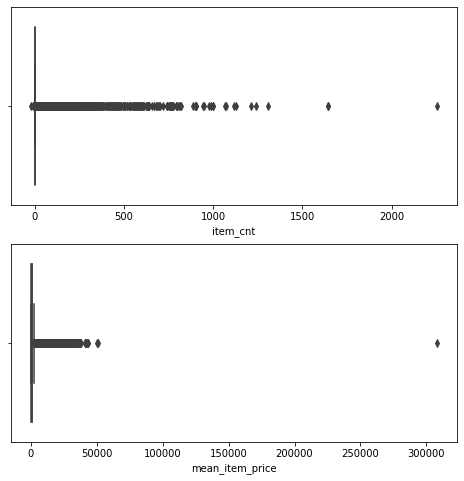

In [16]:
fig, axes = plt.subplots(2,1,figsize=(8,8))
sns.boxplot(x=train_month['item_cnt'], ax=axes[0])
sns.boxplot(x=train_month['mean_item_price'], ax=axes[1])
plt.show()

In [17]:
# remove outliers
train_month = train_month.query('item_cnt >=0 and item_cnt <= 1000 and mean_item_price < 100000')

## Creating the label
the label will be the "next month item cnt"as it is a forecast problem.

In [18]:
train_month['item_cnt_next_month'] = train_month.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

## Feature engineering

### Unitary item prices

In [19]:
train_month['item_price_unit'] = train_month['item_price'] // train_month['item_cnt']
train_month['item_price_unit'].fillna(0, inplace=True)

### Time features

In [20]:
train_month['year'] = train_month['date_block_num'].apply(lambda x: (x//12) + 2013)
train_month['month'] = train_month['date_block_num'].apply(lambda x: x%12)

### Group based features

In [21]:
gp_item_price = train_month.sort_values('date_block_num').groupby(["item_id"], as_index=False).agg({'item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']
train_month = pd.merge(train_month, gp_item_price, on='item_id', how='left')

### Price change from its lowest and highest price

In [22]:
train_month['price_increase'] = train_month['item_price'] - train_month['hist_min_item_price']
train_month['price_decrease'] = train_month['hist_max_item_price'] - train_month['item_price']

### Rolling window features

In [23]:
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    train_month[f'item_cnt_{function_name[i]}'] = train_month.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])


In [24]:
train_month['item_cnt_std'].fillna(0, inplace=True)

### Lag based features

In [25]:
lag_list=[1, 2, 3]
for lag in lag_list:
    ft_name = (f'item_cnt_shifted{lag}')
    train_month[ft_name] = train_month.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_id'].shift(lag)
    train_month[ft_name].fillna(0, inplace=True)
    
    

### Item sales count trend

In [26]:
train_month['item_trend'] = train_month['item_cnt']
for lag in lag_list:
    ft_name = (f'item_cnt_shifted{lag}')
    train_month['item_trend'] -= train_month[ft_name]

train_month['item_trend'] /= len(lag_list) + 1

## Train/Validation Split
The first 3-28 blocks are taken as the train set, validation set are the 29-32 blocks and test set is block 33

In [27]:
train_set = train_month.query('date_block_num >= 3 and date_block_num < 28')
validation_set = train_month.query('date_block_num >=28 and date_block_num < 33')
test_set = train_month.query('date_block_num == 33')

In [28]:
train_set.dropna(subset=['item_cnt_next_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_next_month'], inplace=True)

## Feature engineering after tra

In [29]:
# shop mean 
gp_shop_mean = train_set.groupby(['shop_id']).agg({'item_cnt_next_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)
# item mean 
gp_item_mean = train_set.groupby(['item_id']).agg({'item_cnt_next_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)
# shop and item mean
gp_shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_next_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)
# year mean
gp_year_mean = train_set.groupby(['year']).agg({'item_cnt_next_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)
# month mean
gp_month_mean = train_set.groupby(['month']).agg({'item_cnt_next_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)

In [ ]:
# update train set by mean feature
train_set = pd.merge(train_set, gp_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, gp_shop_item_mean, on=['item_id', 'item_id'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')

# update validation set by mean feature
validation_set = pd.merge(validation_set, gp_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, gp_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, gp_shop_item_mean, on=['item_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')

In [ ]:
# train and validation set input and target variables
X_train = train_set.drop(['item_cnt_next_month', 'date_block_num'], axis=1)
y_train = train_set['item_cnt_next_month'].astype(int)
X_validation = validation_set.drop(['item_cnt_next_month', 'date_block_num'], axis=1)
y_validation = validation_set['item_cnt_next_month'].astype(int)

In [ ]:
# int_features
int_features = ['shop_id', 'item_id', 'year', 'month']
X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

In [ ]:
X_train.head()

In [ ]:
train_month.head()

In [ ]:
train_month.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

In [ ]:
train_month[train_month['item_cnt']>200]

In [ ]:
train_month.head()

In [ ]:
train_month.head()

In [ ]:
train['date'].min().date()

In [ ]:
train['date'].max().date()